<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


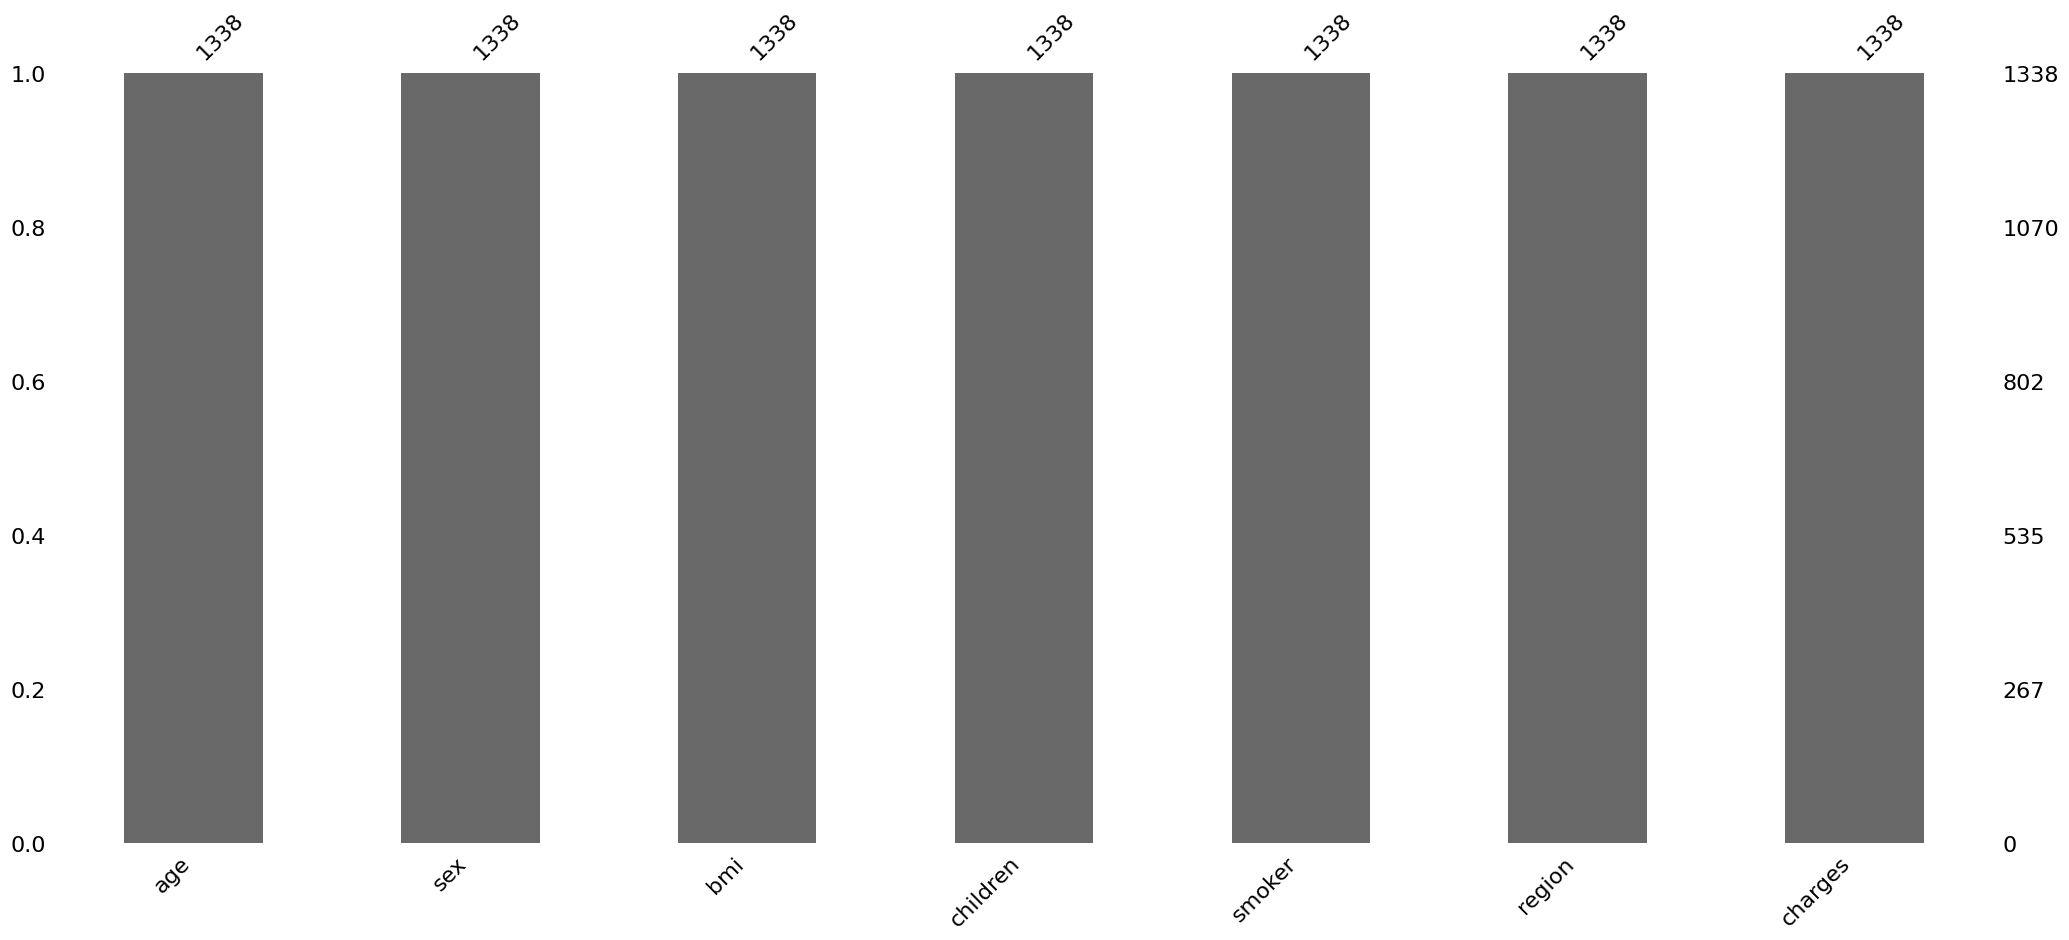

In [24]:
# display plots inline
%matplotlib inline

# import packages
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# load dataset
df = pd.read_csv('expenses.csv')

# check for missing values
msno.bar(df)

# check dataset variables and summary statistics
df.info()
df.describe()
#df.head()

array([[<AxesSubplot: title={'center': 'charges'}>]], dtype=object)

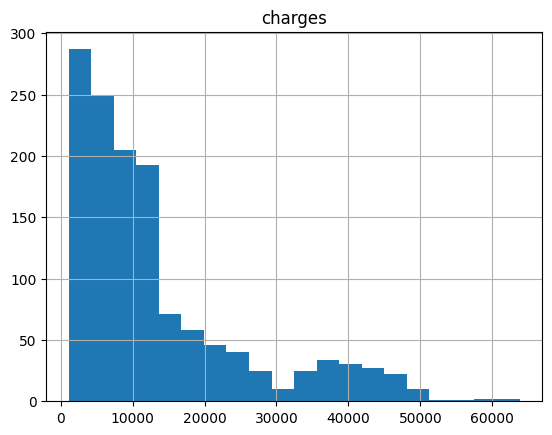

In [25]:
# check distribution of dependent variable-'charges'

df.hist(column='charges', bins=20)

array([[<AxesSubplot: title={'center': 'ln_charges'}>]], dtype=object)

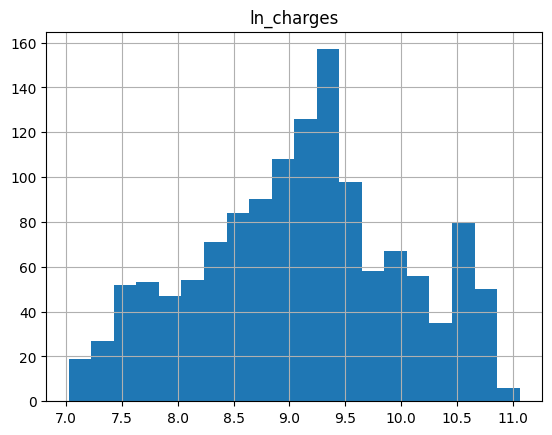

In [26]:
# normalize dependent variable
df['ln_charges'] = np.log(df['charges'])

df.hist(column='ln_charges', bins=20)

In [27]:
# display correlation matrix
print(df.corr().round(2))

             age   bmi  children  charges  ln_charges
age         1.00  0.11      0.04     0.30        0.53
bmi         0.11  1.00      0.01     0.20        0.13
children    0.04  0.01      1.00     0.07        0.16
charges     0.30  0.20      0.07     1.00        0.89
ln_charges  0.53  0.13      0.16     0.89        1.00


/home/nimnathw/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='age', ylabel='ln_charges'>

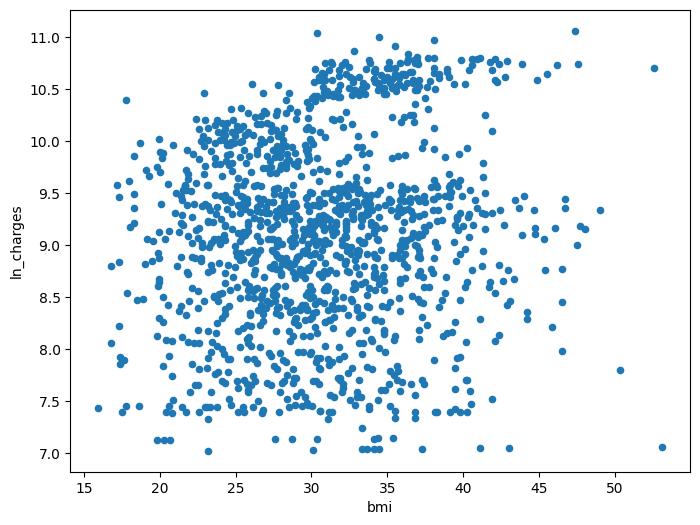

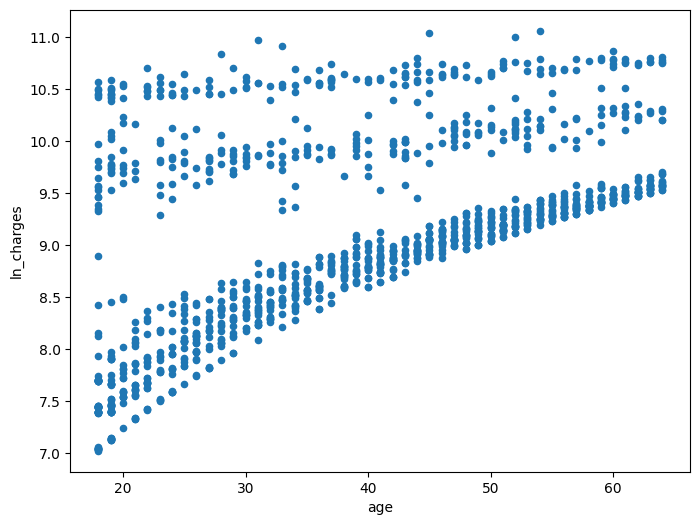

In [28]:
# display scatterplots
df.plot(kind='scatter', x='bmi', y='ln_charges', figsize=(8,6))
df.plot(kind='scatter', x='age', y='ln_charges', figsize=(8,6))

In [29]:
# look for response categories
print(df['sex'].value_counts())
print(df['smoker'].value_counts())
print(df['region'].value_counts())

# convert string data to numerical
df['male'] = df['sex'] == 'male'
df['smoker'] = df['smoker'] == 'yes'

male      676
female    662
Name: sex, dtype: int64
no     1064
yes     274
Name: smoker, dtype: int64
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


In [30]:
# create Numpy 1-D and 2-D arrays for two models
X1 = df[['male', 'bmi', 'children', 'smoker']].values
y = df['ln_charges'].values

X2 = df[['male', 'bmi', 'children', 'smoker']].values
y = df['ln_charges'].values

# split data into train test sets
X1_train, X1_test, y_train, Y_test = train_test_split(X1, y, test_size = 0.3, random_state=1)

# initialize Linear Regression model
model = LinearRegression()

# fit model
model.fit(X1_train, y_train)

# predict y values on test set
y_test_predicted = model.predict(X1_test)

# split data into train test sets
# same random_state to ensure the same splits
X2_train, X2_test, y_train, y_test = train_test_split(X2, y,  test_size = 0.3, random_state=1)

# initialize Linear Regression model
model2 = LinearRegression()

# fit model
model2.fit(X2_train, y_train)

# predict y values on test set
y_test_predicted2 = model2.predict(X2_test)

# show mean squared errors
print(mean_squared_error(y_test, y_test_predicted2).round(2))

# show R-squared

# show model coefficients
print('model intercept\n')
print(model.intercept_.round(2))
print('model coefficents\n')
print(pd.DataFrame(model.coef_.round(2), df[['male', 'bmi', 'children', 'smoker']].columns, columns=['coef']).sort_values(by='coef', ascending=False))



0.45
model intercept

8.09
model coefficents

          coef
smoker    1.54
children  0.10
bmi       0.02
male     -0.09
